In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import argparse
qml.QubitStateVector = qml.StatePrep

from variational_lse_solver import VarLSESolver


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""


Matplotlib is building the font cache; this may take a moment.


'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

In [15]:

# unitary representation of Paulis
I_ = np.array([[1.0, 0.0], [0.0, 1.0]])
X_ = np.array([[0.0, 1.0], [1.0, 0.0]])
Y_ = np.array([[0.0, -1.j], [1.j, 0.0]])
Z_ = np.array([[1.0, 0.0], [0.0, -1.0]])

a = ["III", "XZI", "XII"]
b = np.ones(8)/np.sqrt(8)



In [41]:
N_runs = 10
local_results = np.zeros([len(b), N_runs])
global_results = np.zeros([len(b), N_runs])

for i in range(N_runs):
    lse_local = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=True, 
                lr=0.1, 
                steps=50) 

    lse_global = VarLSESolver(a, 
                b, 
                coeffs=[1.0, 0.2, 0.2], 
                method="hadamard", 
                local=False, 
                lr=0.1, 
                steps=50) 
    
    solution_local, _ = lse_local.solve()
    solution_global, _ = lse_global.solve()

    local_results[:, i] = solution_local
    global_results[:, i] = solution_global

Epoch 1/1: 100%|██████████| 50/50 [00:01<00:00, 30.50it/s, best loss=0.00866, last improvement in step=39, loss=0.0334] 


In [42]:
# compute normalized classical solution for comparison, therefore first re-compose system matrix A
A = 1.0 * np.kron(I_, np.kron(I_, I_)) + 0.2 * np.kron(X_, np.kron(Z_, I_)) + 0.2 * np.kron(X_, np.kron(I_, I_))
classical_solution = np.linalg.solve(A, b)
normalized_classical_solution = np.square(classical_solution / np.linalg.norm(classical_solution))

# print and compare solutions
print('\nQuantum:\n|', end='')
for s in solution_global:
    print(f' {s:.4f} |', end='')
print('\nClassical:\n|', end='')
for s in normalized_classical_solution:
    print(f' {s:.4f} |', end='')
print()


Quantum:
| 0.0529 | 0.0526 | 0.1971 | 0.1959 | 0.0532 | 0.0529 | 0.1983 | 0.1970 |
Classical:
| 0.0845 | 0.0845 | 0.1655 | 0.1655 | 0.0845 | 0.0845 | 0.1655 | 0.1655 |


<BarContainer object of 8 artists>

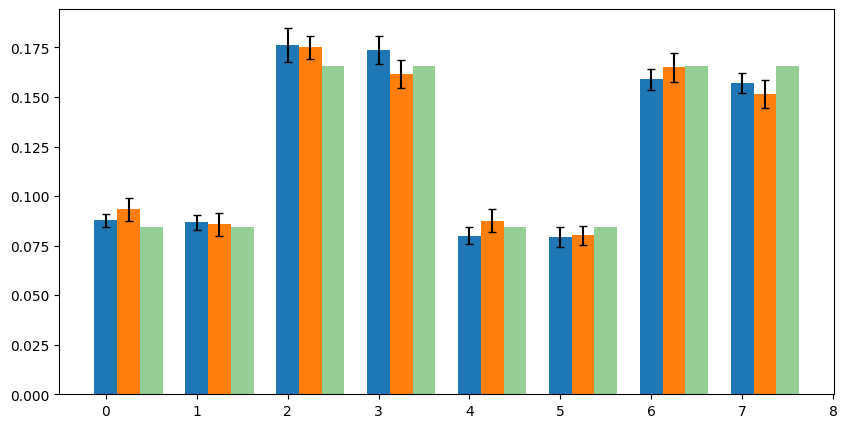

In [43]:
plt.figure(figsize=(10, 5))

x = np.arange(len(normalized_classical_solution)) 
width = 0.25 
multiplier = 0

plt.bar(x, np.mean(local_results, axis=1), yerr=np.std(local_results, axis=1)/np.sqrt(len(local_results)), width=width, capsize=3, label='Local')
plt.bar(x + width, np.mean(global_results, axis=1), yerr=np.std(global_results,axis=1)/np.sqrt(len(local_results)), width=width, capsize=3, label='Global')
plt.bar(x + 2*width, normalized_classical_solution, width = width, label='Classical', alpha=0.5)